# LGBMRegressor를 이용한 삼성전자의 다음날 종가&상승or하락 예측

1990년 1월 1일부터 2022년 12월 31일의 데이터로 2023년의 삼성전자 주가를 예측합니다.

In [1]:
!pip install finance-datareader

FinanceDataReader 라이브러리로 1990년 1월 1일부터 2023년 8월 4일까지의 삼성전자 주가 데이터를 불러옵니다.

먼저, 직전 몇 거래일 동안의 데이터로 다음날 종가를 예측할지 결정합니다.
<br>
<br>
이를 위해, 5~200일 중 가장 결정계수 값이 높은 수를 찾습니다.

35개의 직전 거래일 데이터를 사용하는 것이 가장 결정계수값이 높았습니다.
<br>
<br>
이제 모델을 학습해보겠습니다.

In [2]:
import pandas as pd
import FinanceDataReader as fdr

# 종목 코드 설정
symbol_list = {
    'NASDAQ': '^IXIC',
    'S&P500': '^GSPC',
    'Dow Jones': '^DJI',
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Alphabet A': 'GOOGL',
    'Amazon': 'AMZN',
    'Berkshire Hathaway': 'BRK-A',
    'NVIDIA': 'NVDA',
    'Meta Platforms': 'META',
    'Tesla': 'TSLA',
    'Visa': 'V',
    'UnitedHealth Group': 'UNH'
}

# start_date = '2000-01-01'  # 시작 날짜 설정
end_date = '2022-12-31'    # 종료 날짜 설정

all_data = {name: fdr.DataReader(code) for name, code in symbol_list.items()}

In [3]:
apple_data = all_data['Apple']
print(apple_data.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099584  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094388  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087461  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089625   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092224   73449600


In [12]:
import numpy as np

def preprocess_stock_data(df):
    df = df.copy()
    df['Date'] = df.index

    df.reset_index(drop=True, inplace=True)

    df['Next_Day_Direction'] = df['Close'].shift(-1) - df['Close']

    # 'Next_Day_Direction' 값을 '상승', '하락'으로 변환
    df['Next_Day_Direction'] = df['Next_Day_Direction'].apply(lambda x: 1 if x >= 0 else 0)
    df = df.iloc[:-1]


    # 이동평균을 계산하는 함수를 정의합니다.
    def calculate_moving_average(df, column, window):
        return df[column].rolling(window=window).mean()

    # 여러 이동평균 기간을 설정합니다.
    moving_average_periods = [5, 10, 20, 60, 120, 240]

    # 이동평균을 구하고 데이터 프레임에 새 열로 추가합니다.
    for period in moving_average_periods:
        column_name = f"MA_{period}"
        df[column_name] = calculate_moving_average(df, 'Close', period)


        # 이동표준편차를 계산하는 함수를 정의합니다.
    def calculate_moving_std(df, column, window):
        return df[column].rolling(window=window).std()

    # 볼린저 밴드를 계산하는 함수를 정의합니다.
    def calculate_bollinger_bands(df, column, window):
        MA = calculate_moving_average(df, column, window)
        STD = calculate_moving_std(df, column, window)
        return MA - 2 * STD, MA + 2 * STD

    # 볼린저 밴드 기간을 설정합니다.
    bollinger_band_period = 20

    # 볼린저 밴드를 계산합니다.
    df['BB_Lower'], df['BB_Upper'] = calculate_bollinger_bands(df, 'Close', bollinger_band_period)


        # RSI를 계산하는 함수를 정의합니다.
    def calculate_rsi(df, column, window=14):
        delta = df[column].diff()
        gain, loss = delta.copy(), delta.copy()
        gain[gain < 0] = 0
        loss[loss > 0] = 0

        # Wilder's exponential moving average
        avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
        avg_loss = abs(loss.ewm(com=window - 1, min_periods=window).mean())

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        return rsi

    # RSI 기간을 설정합니다. 일반적으로 14일을 사용합니다.
    rsi_period = 14

    # RSI를 계산합니다.
    df['RSI'] = calculate_rsi(df, 'Close', rsi_period)

    # 지수이동평균(EMA)을 계산하는 함수를 정의합니다.
    def calculate_ema(df, column, window):
        return df[column].ewm(span=window).mean()

    # MACD를 계산하는 함수를 정의합니다.
    def calculate_macd(df, column, short_window=12, long_window=26):
        short_ema = calculate_ema(df, column, short_window)
        long_ema = calculate_ema(df, column, long_window)
        return short_ema - long_ema

    # MACD 시그널을 계산하는 함수를 정의합니다.
    def calculate_macd_signal(df, column, macd_window=9):
        return df[column].ewm(span=macd_window).mean()

    # MACD를 계산합니다.
    df['MACD'] = calculate_macd(df, 'Close')

    # MACD 시그널을 계산합니다.
    df['MACD_Signal'] = calculate_macd_signal(df, 'MACD')


    # True Range를 계산하는 함수를 정의합니다.
    def calculate_true_range(df, high_col='High', low_col='Low', close_col='Close'):
        high_low = df[high_col] - df[low_col]
        high_close = df[high_col] - df[close_col].shift(1)
        low_close = df[low_col] - df[close_col].shift(1)
        ranges = pd.concat([high_low, high_close.abs(), low_close.abs()], axis=1)
        true_range = ranges.max(axis=1)
        return true_range

    # +DMI, -DMI를 계산하는 함수를 정의합니다.
    def calculate_dm(df, high_col='High', low_col='Low'):
        up_move = df[high_col] - df[high_col].shift(1)
        down_move = df[low_col].shift(1) - df[low_col]

        plus_dm = pd.Series(index=df.index, dtype='float64')
        minus_dm = pd.Series(index=df.index, dtype='float64')

        for i in range(len(df)):
            if up_move[i] > down_move[i] and up_move[i] > 0:
                plus_dm.iloc[i] = up_move[i]
            else:
                plus_dm.iloc[i] = 0
            if down_move[i] > up_move[i] and down_move[i] > 0:
                minus_dm.iloc[i] = down_move[i]
            else:
                minus_dm.iloc[i] = 0

        return plus_dm, minus_dm


    # ADX를 계산하는 함수를 정의합니다.
    def calculate_adx(df, window=14, high_col='High', low_col='Low', close_col='Close'):
        true_range = calculate_true_range(df)
        plus_dm, minus_dm = calculate_dm(df)

        atr = true_range.rolling(window=window).sum() / window
        plus_di = 100 * (plus_dm.rolling(window=window).sum() / atr)
        minus_di = 100 * (minus_dm.rolling(window=window).sum() / atr)

        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
        adx = dx.rolling(window=window).mean()

        return adx

    # ADX를 계산합니다.
    df['ADX'] = calculate_adx(df)

    # 전환선 (Conversion Line)를 계산하는 함수를 정의합니다.
    def calculate_conversion_line(df, high_col='High', low_col='Low', n1=9):
        high_n1 = df[high_col].rolling(window=n1).max()
        low_n1 = df[low_col].rolling(window=n1).min()
        conversion_line = (high_n1 + low_n1) / 2
        return conversion_line

    # 기준선 (Base Line)를 계산하는 함수를 정의합니다.
    def calculate_base_line(df, high_col='High', low_col='Low', n2=26):
        high_n2 = df[high_col].rolling(window=n2).max()
        low_n2 = df[low_col].rolling(window=n2).min()
        base_line = (high_n2 + low_n2) / 2
        return base_line

    # 선행 스팬 A를 계산하는 함수를 정의합니다.
    def calculate_leading_span_A(conversion_line, base_line):
        leading_span_A = (conversion_line + base_line) / 2
        return leading_span_A

    # 선행 스팬 B를 계산하는 함수를 정의합니다.
    def calculate_leading_span_B(df, high_col='High', low_col='Low', n3=52):
        high_n3 = df[high_col].rolling(window=n3).max()
        low_n3 = df[low_col].rolling(window=n3).min()
        leading_span_B = (high_n3 + low_n3) / 2
        return leading_span_B

    # 전환선 (Conversion Line) 계산
    df['Conversion_Line'] = calculate_conversion_line(df)

    # 기준선 (Base Line) 계산
    df['Base_Line'] = calculate_base_line(df)

    # 선행 스팬 A 계산
    df['Leading_Span_A'] = calculate_leading_span_A(df['Conversion_Line'], df['Base_Line'])

    # 선행 스팬 B 계산
    df['Leading_Span_B'] = calculate_leading_span_B(df)


    # 각 column에 0 몇개인지 확인
    for col in df.columns:
        missing_rows = df.loc[df[col]==0].shape[0]
        # print(col + ': ' + str(missing_rows))
    df['Volume'] = df['Volume'].replace(0, np.nan)
    df = df.dropna()
    df.isnull().sum()

    return df

In [13]:
processed_data = {name: preprocess_stock_data(df) for name, df in all_data.items()}

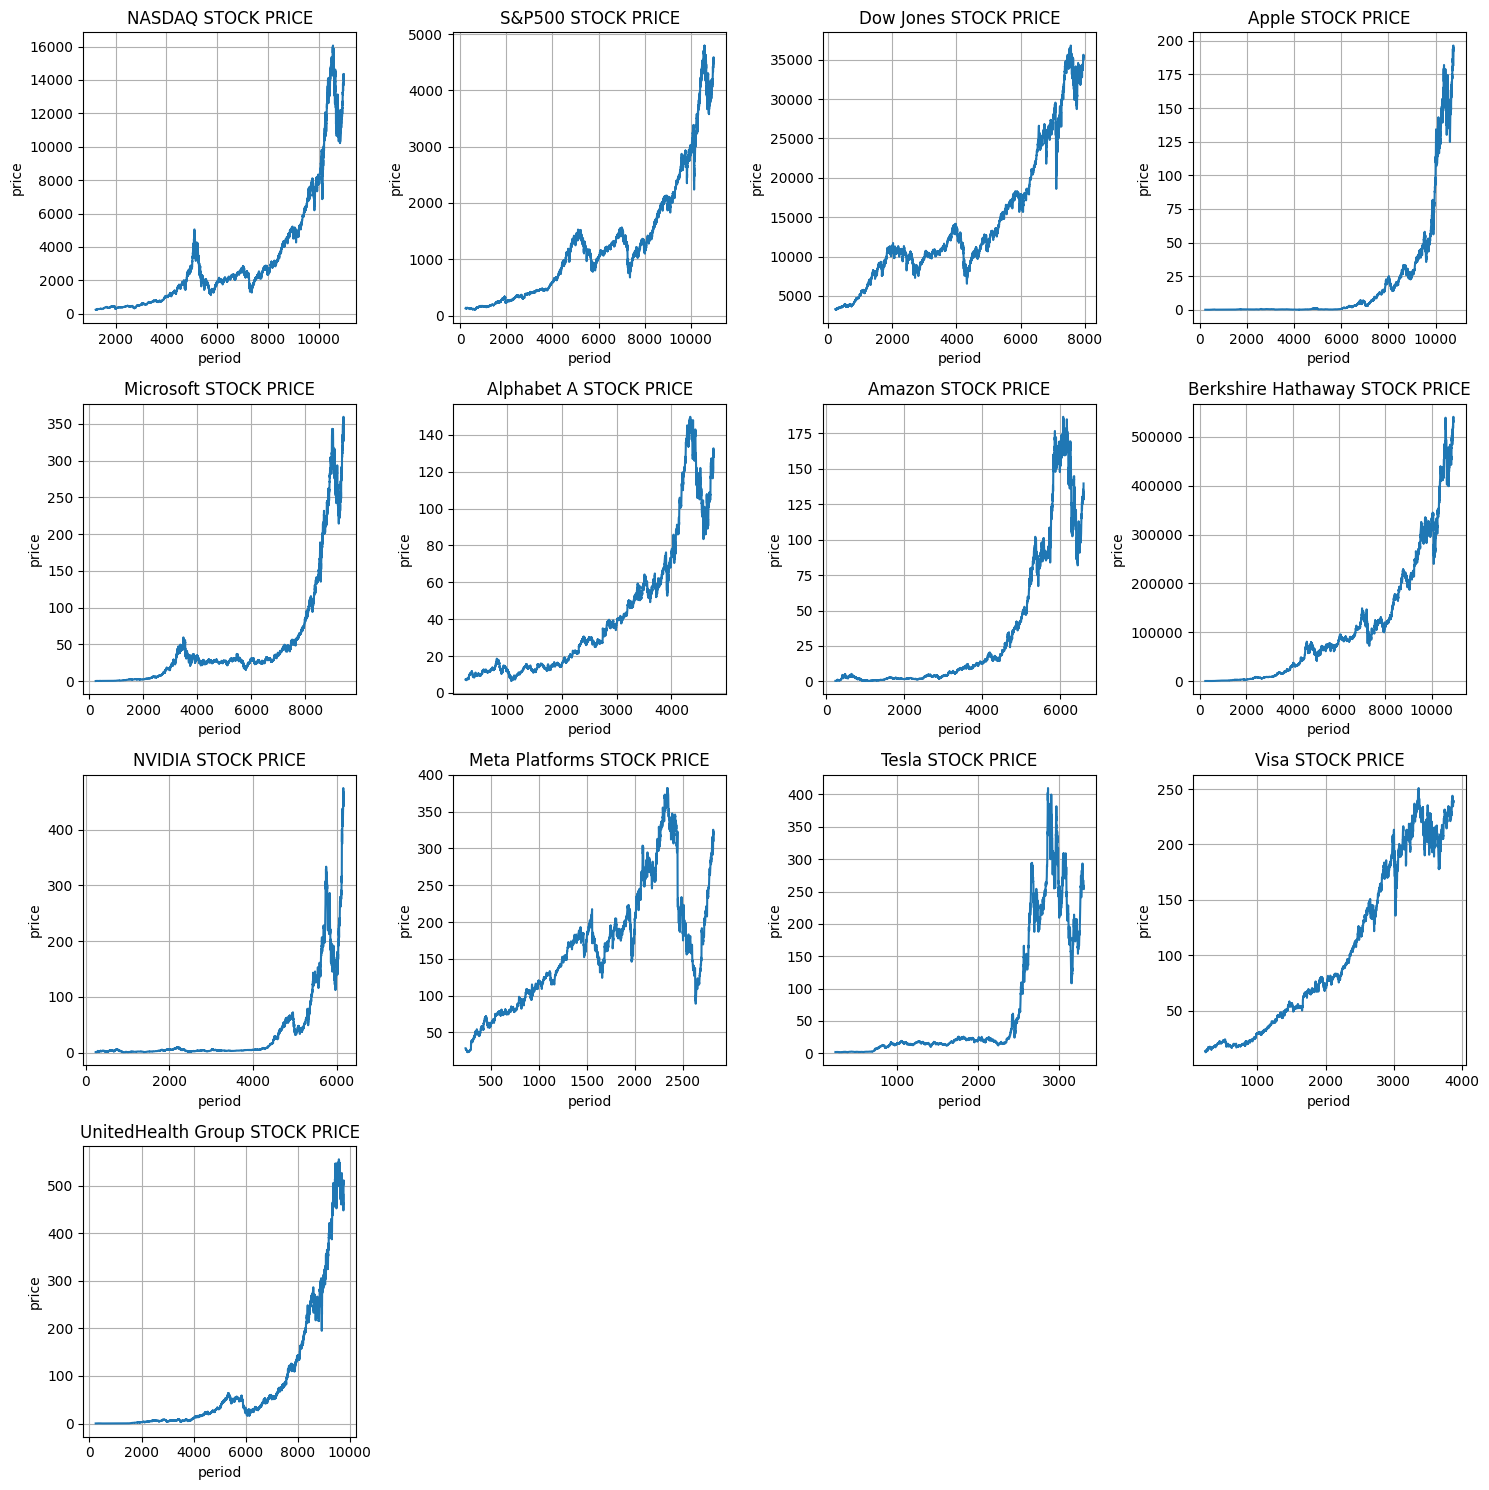

In [14]:
import matplotlib.pyplot as plt

# 4x4 그리드 레이아웃을 사용하여 각 종목 차트를 표시합니다.
# nrows와 ncols는 골고루 결정
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for ax, (name, df) in zip(axes.flatten(), processed_data.items()):
    ax.plot(df['Close'], label='Close')
    ax.set_title(name + ' STOCK PRICE')
    ax.set_ylabel('price')
    ax.set_xlabel('period')
    ax.grid()

# 사용하지 않는 서브플롯 제거
n_plots = len(processed_data)
for i in range(n_plots, nrows * ncols):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
def create_input_output_data(df, window_size=60, column="Close"):
    data = df[column].values
    next_day_direction = df['Next_Day_Direction'].values[window_size:] # 추가된 부분
    X, Y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        Y.append(next_day_direction[i-window_size]) # Y 값을 next_day_direction을 기반으로 변경하였습니다.

    return np.array(X), np.array(Y).astype(int)


def scale_data(X):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_X = scaler.fit_transform(X)
    return scaled_X, scaler

def rescale_output_data(scaler, output_data):
    output_2d = np.array(output_data).reshape(-1, 1)
    return scaler.inverse_transform(output_2d)

def generate_lstm(units=10, dropout_ratio=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_ratio))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_ratio))
    model.add(Flatten()) # Flatten the last LSTM layer output before Dense layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy']) # 손실함수와 평가지표 변경
    return model


def train_lstm_model(X_train, y_train, X_valid, y_valid, model, stock_name, batch_size=32, epochs=5):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Setup model checkpoint for the specific stock
    model_name = "LSTM_ensemble_" + stock_name + ".h5"
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min')
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)
    return history, model

In [ ]:
# 각 종목에 대한 데이터를 전처리하고 LSTM 모델을 훈련합니다.
column = "Close"
window_size = 60
ensemble_lstm_models = []

for stock_name, stock_data in all_data.items():
    print(f"Processing {stock_name}")
    preprocessed_stock_data = preprocess_stock_data(stock_data)
    X, Y = create_input_output_data(preprocessed_stock_data, window_size, column)
    X, input_scaler = scale_data(X) # 스케일링된 입력 데이터와 해당 scaler를 반환

    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, shuffle=False)

    # 데이터 차원 변경
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

    lstm_model = generate_lstm()
    history, trained_lstm_model = train_lstm_model(X_train, y_train, X_valid, y_valid, lstm_model, stock_name)

    ensemble_lstm_models.append((stock_name, trained_lstm_model, input_scaler))

Processing NASDAQ
Epoch 1/5
244/244 [==============================] - 125s 495ms/step - loss: 0.6872 - accuracy: 0.5574 - val_loss: 0.6932 - val_accuracy: 0.5260
Epoch 2/5
244/244 [==============================] - 18s 75ms/step - loss: 0.6859 - accuracy: 0.5568 - val_loss: 0.6973 - val_accuracy: 0.4905
Epoch 3/5
244/244 [==============================] - 18s 73ms/step - loss: 0.6865 - accuracy: 0.5559 - val_loss: 0.6934 - val_accuracy: 0.5131
Epoch 4/5
244/244 [==============================] - 22s 91ms/step - loss: 0.6864 - accuracy: 0.5577 - val_loss: 0.6948 - val_accuracy: 0.5039
Epoch 5/5
244/244 [==============================] - 19s 78ms/step - loss: 0.6860 - accuracy: 0.5577 - val_loss: 0.6997 - val_accuracy: 0.4746
Processing S&P500
Epoch 1/5
268/268 [==============================] - 22s 68ms/step - loss: 0.6916 - accuracy: 0.5333 - val_loss: 0.6946 - val_accuracy: 0.5334
Epoch 2/5
268/268 [==============================] - 16s 60ms/step - loss: 0.6915 - accuracy: 0.5336 - v

In [ ]:
def ensemble_predict(models, input_data):
    predictions_ensemble = []
    for _, model, scaler in models:
        prediction = model.predict(input_data)
        binary_prediction = np.where(prediction > 0.5, 1, 0)
        predictions_ensemble.append(binary_prediction)

    final_prediction = np.round(np.mean(predictions_ensemble, axis=0))
    return final_prediction

In [ ]:
from sklearn.metrics import accuracy_score

# 종목 코드 설정
new_symbol_list = {
    'Exxon Mobil': 'XOM',
    'Johnson & Johnson': 'JNJ'
}

# 종목별 주가 데이터 저장
all_new_data = {name: fdr.DataReader(symbol) for name, symbol in new_symbol_list.items()}


for stock_name, stock_data in all_new_data.items():
    print(f"Processing {stock_name}")
    preprocessed_stock_data = preprocess_stock_data(stock_data)
    X, Y = create_input_output_data(preprocessed_stock_data, window_size, column)
    X_test = X.reshape(X.shape[0], X.shape[1], 1)

    ensemble_prediction = ensemble_predict(ensemble_lstm_models, X_test)
    print(f"Ensemble prediction shape: {ensemble_prediction.shape}")

    # 성능 평가 (예: 정확도)
    accuracy = accuracy_score(Y, ensemble_prediction)
    print(f"{stock_name} Accuracy: {round(accuracy, 4)}")